# NIPS Papers

Ce notebook a pour but d'explorer les différentes communautés trouvable à partir des données NIPS.
Il faudra s'assurer d'avoir suivi les instructions d'installation disponibles dans le README afin de lancer les cellules du notebook.

In [1]:
# IMPORT
import os
import itertools
import pandas as pd

import networkx as nx
from pyvis.network import Network
from grave import plot_network
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from src.const import RAW_DATA_DIR, HTML_REPORTS_DIR
from src.dataloader.csv_loader import CSVLoader
from src.dataloader.sqlite_loader import SQLITELoader
from src.utils.dataviz import pyvis_graph

On commence par lire les fichiers (téléchargeable [ici](https://www.kaggle.com/datasets/benhamner/nips-papers) et à déposer sous data/raw).

Le chemin par défaut dans le code ci-dessous est data/raw mais peut être modifié en remplaçant RAW_DATA_DIR par le chemin du répertoire contenant les fichiers.
Si vous voulez utiliser le code tel quel l'arborescence sous data devra être la suivante : 

![arborescence](../reports/images/arbo.png)

Deux méthodes de lecture sont disponibles : via les CSV ou via la base de données SQLite.

In [2]:
help(CSVLoader.read_filter_data)

Help on function read_filter_data in module src.dataloader.csv_loader:

read_filter_data(self, years: Optional[List[int]] = None) -> dict[str, pandas.core.frame.DataFrame]
    Read CSV and filter according to years. Verification on data schema and unique key.
    
    Args:
        years (List[int]): list of years to keep
    
    Returns:
        dict[str, pd.DataFrame]: Dict with three elements : "papers", "authors" and "paper_authors"



In [3]:
help(SQLITELoader.read_filter_data)

Help on function read_filter_data in module src.dataloader.sqlite_loader:

read_filter_data(self, years: Optional[List[int]] = None) -> dict[str, pandas.core.frame.DataFrame]
    Read from SQLite Database and filter according to years. Verification on data schema and unique key.
    
    Args:
        years (List[int]): list of years to keep
    
    Returns:
        dict[str, pd.DataFrame]: Dict with three elements : "papers", "authors" and "paper_authors"



In [4]:
loader = CSVLoader(RAW_DATA_DIR)
data = loader.read_filter_data(years=[2017])
authors_df = data["authors"]
paper_authors_df = data["paper_authors"]
papers_df = data["papers"]

In [5]:
# loader = SQLITELoader(RAW_DATA_DIR)
# data = loader.read_filter_data(years=[2016])
# authors_df = data["authors"]
# paper_authors_df = data["paper_authors"]
# papers_df = data["papers"]

In [6]:
authors_df.head(),paper_authors_df.head()

(      id            name
 4  10000   Artur Speiser
 5  10001    Fabio Cecchi
 6  10002     Nidhi Hegde
 7  10003  Ethan Elenberg
 8  10004   Moran Feldman,
           id  paper_id  author_id
 18345  18346      6606       9357
 18346  18347      6606       9358
 18347  18348      6606       9359
 18348  18349      6606      10481
 18349  18350      6606      10482)

## Création du graphe avec Networkx

Les noms ne peuvent pas être utilisés de manière équivalente aux id (non unicité). On continuera donc avec les ids dans un premier temps.

In [7]:
authors_df["name"].is_unique

False

In [8]:
G = nx.Graph()

# For each paper
for paper_id, author_id in paper_authors_df.groupby("paper_id")["author_id"]:
    # Combine authors 2 by 2
    for u, v in itertools.combinations(author_id, 2):
        if G.has_edge(u, v):
            continue # TODO modify this to add to the weight of the edge
        else:
            G.add_edge(u, v)

authors_name_dict = authors_df.dropna(how='any').set_index("id").to_dict()["name"]
nx.set_node_attributes(G, {key: {"label":value} for key, value in authors_name_dict.items()})

Un graphe plus _complexe_ peut être créé mais il serait alors plus lourd et plus long à executer:

In [9]:
# authors_name_dict = authors_df.set_index("id").to_dict()["name"]

# for paper_id, author_id in paper_authors_df.groupby('paper_id')['author_id']:
#     for u, v in itertools.combinations(author_id, 2):
#         # if node u doesn't exist create
#         if not G.has_node(u) :
#             G.add_node(u, label=authors_name_dict[u], papers = [paper_id])
#         else :
#             node_attr_papers = nx.get_node_attributes(G, "papers")[u]
#             nx.set_node_attributes(G, {u:{"papers":node_attr_papers + [paper_id]}} ) # adding current paper to list of papers

#         # if node v doesn't exist create
#         if not G.has_node(v) :
#             G.add_node(v, label=authors_name_dict[v], papers = [paper_id])
#         else :
#             node_attr_papers = nx.get_node_attributes(G, "papers")[v]
#             nx.set_node_attributes(G, {v:{"papers":node_attr_papers + [paper_id]}} ) # adding current paper to list of papers

#         if G.has_edge(u, v):
#             continue
#         else:
#             G.add_edge(u, v)

### Visualisation du graphe

Le graphe est très dense, il est difficile de le visualiser en utilisant networkx directement. On utilisera Pyvis pour les visualisations suivantes.

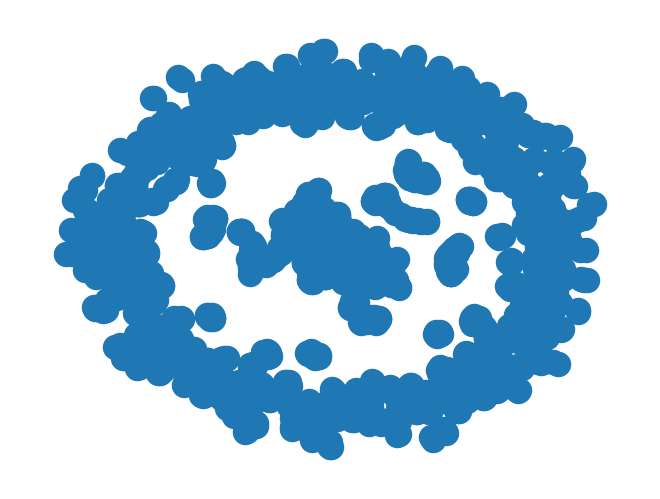

In [10]:
# Visualisation avec la fonction de networkx
nx.draw(G)

In [11]:
# Visualisation avec Pyvis
pyvis_graph(G, "graph_authors_0")

graph_authors_0.html


Pour une visualisation du graphe dynamique et claire, on peut le sauvegarder au format html :

In [12]:
nt = Network(height="950px", width="1680px", directed=False)
nt.from_nx(G)
nt.save_graph(os.path.join(HTML_REPORTS_DIR, "graph_authors.html"))

## Détection de communauté

Networkx propose sa propre [implémentation](https://networkx.org/documentation/stable/reference/algorithms/community.html) de détection de communauté via la méthode de Louvain.

In [13]:
communities = nx.community.louvain_communities(G, seed = 125)
print(f"Modularity : {round(nx.community.modularity(G, communities),2)}")

Modularity : 0.98


La modularité nous permet de quantifier la _qualité_ de notre partition ([ref](https://www.pnas.org/doi/pdf/10.1073/pnas.0601602103)).

On cherche à visualiser les 2 plus grandes communautées.

In [14]:
#  sorting by length of each communities
sorted_communities = sorted(communities, key=len, reverse=True)  # type: ignore

largest_community = sorted_communities[0]
second_largest_community = sorted_communities[1]

print(f"Largest community has {len(largest_community)} authors",
    f"Second largest community has {len(second_largest_community)} authors",
    sep="\n")

Largest community has 85 authors
Second largest community has 63 authors


In [15]:
pyvis_graph(G.subgraph(largest_community),
            "graph_largest_community")

graph_largest_community.html


In [16]:
pyvis_graph(G.subgraph(second_largest_community),
            "graph_second_largest_community")

graph_second_largest_community.html


On affiche toutes les communautés mais en mettant en couleur les 10 plus grandes (en nombre d'auteur.ice.s).

In [17]:
colors = ["rgba(158, 1, 66, 1)",
          "rgba(213, 62, 79, 1)",
          "rgba(244, 109, 67, 1)",
          "rgba(253, 174, 97, 1)",
          "rgba(254, 224, 139, 1)",
          "rgba(230, 245, 152, 1)",
          "rgba(171, 221, 164, 1)",
          "rgba(102, 194, 165, 1)",
          "rgba(50, 136, 189, 1)",
          "rgba(94, 79, 162, 1)"]
dict_color = {}
for i, col in enumerate(colors):
    dict_color.update({author_id:{"color":col} for author_id in sorted_communities[i]})

nx.set_node_attributes(G, dict_color)

In [18]:
pyvis_graph(G,
            "graph_authors_1")

graph_authors_1.html


## Mise en évidence d'auteur.ice.s remarquables

Pour mettre en évidence des auteur.ice.s remarquables, on commence par créer les features qui vont permettre de les différencier : 
- le nombre de personne avec lesquels iels ont publiés
- le nombre de papier publié

In [19]:
nb_edge_author = dict(G.degree())
author_features = pd.DataFrame(nb_edge_author.values(), columns=["nb_edge"])
author_features.index = nb_edge_author.keys()

author_count = paper_authors_df.groupby("author_id").paper_id.count()
author_features = author_features.merge(author_count, left_index=True, right_index=True)

author_features.describe()

,nb_edge,paper_id
count,2019.000000,2019.000000
mean,4.140664,1.226350
std,3.044439,0.613508
min,1.000000,1.000000
25%,2.000000,1.000000
50%,3.000000,1.000000
75%,5.000000,1.000000
max,34.000000,10.000000


On vérifie la corrélation entre nos variables.

           nb_edge  paper_id
nb_edge   1.000000  0.571135
paper_id  0.571135  1.000000


<Axes: xlabel='nb_edge', ylabel='paper_id'>

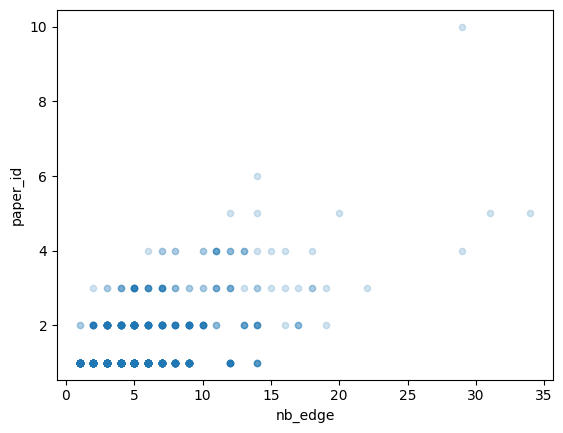

In [20]:
print(author_features.corr())
author_features.plot(x="nb_edge", y="paper_id", kind="scatter", alpha=0.2)

### Isolation Forest

On cherche à identifier des outliers parmi les auteur.ice.s. 
On utilise l'isolation forest pour isoler des profils atypiques.

In [21]:

model = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto',max_features=1.0)
model.fit(author_features[["nb_edge", "paper_id"]])
outliers = (model.predict(author_features[["nb_edge", "paper_id"]]) == -1)
print(f"Nombre d'outliers: {sum(outliers)}/{len(outliers)}")

Nombre d'outliers: 478/2019


<Axes: xlabel='nb_edge', ylabel='paper_id'>

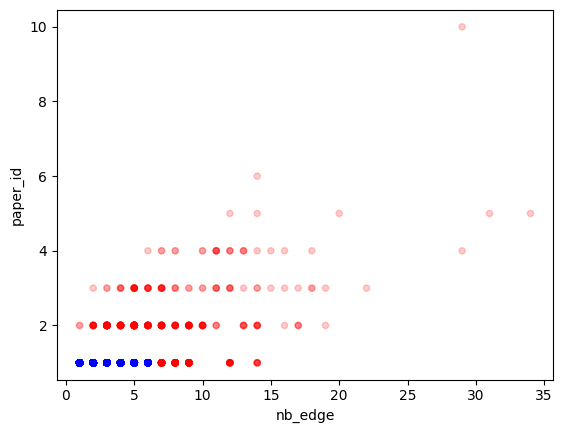

In [22]:
author_features["color"]="blue"
author_features.loc[outliers,"color"] = "red"
author_features.plot(x="nb_edge", y="paper_id", kind="scatter", color=author_features["color"],alpha=0.2)

On peut relancer l'isolation Forest sur les outliers pour réduire le nombre d'outliers.

In [23]:
author_outlier = author_features[outliers].drop("color",axis=1)

           nb_edge  paper_id
nb_edge   1.000000  0.298571
paper_id  0.298571  1.000000


<Axes: xlabel='nb_edge', ylabel='paper_id'>

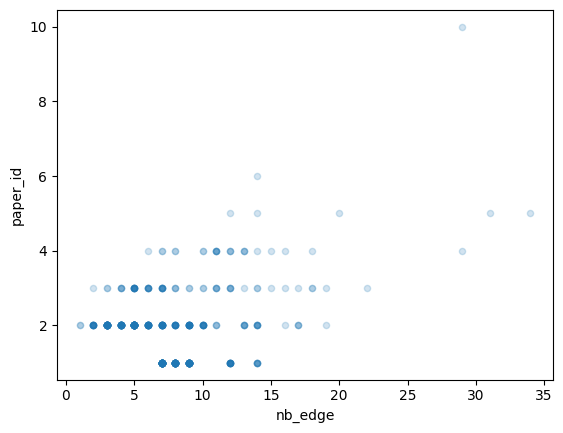

In [24]:
print(author_outlier.corr())
author_outlier.plot(x="nb_edge", y="paper_id", kind="scatter", alpha=0.2)

In [25]:
model = IsolationForest(n_estimators=500, max_samples='auto', contamination='auto',max_features=1.0)
model.fit(author_outlier)
outliers = (model.predict(author_outlier) == -1)
print(f"Nombre d'outliers: {sum(outliers)}/{len(outliers)}")

Nombre d'outliers: 114/478


<Axes: xlabel='nb_edge', ylabel='paper_id'>

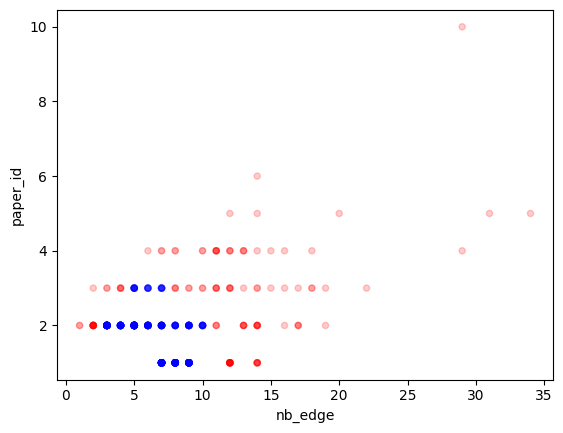

In [26]:
author_outlier["color"]="blue"
author_outlier.loc[outliers,"color"] = "red"
author_outlier.plot(x="nb_edge", y="paper_id", kind="scatter", color=author_outlier["color"],alpha=0.2)

In [27]:
nx.set_node_attributes(G, {key: {"color": "rgba(0, 0, 0, 0.5)"} for key in author_outlier[outliers].index})
pyvis_graph(G,
            "graph_authors_outlier_0")

graph_authors_outlier_0.html


### Local Outlier Factor
On essaye maintenant d'utiliser la méthode Local Outlier Factor qui permet de donner un score d'outlier aux données en fonction de leur proximité à des voisins.

In [28]:
lof = LocalOutlierFactor(n_neighbors = author_features.shape[0]//3 , novelty=True)
y_pred = lof.fit(author_features[["nb_edge", "paper_id"]])

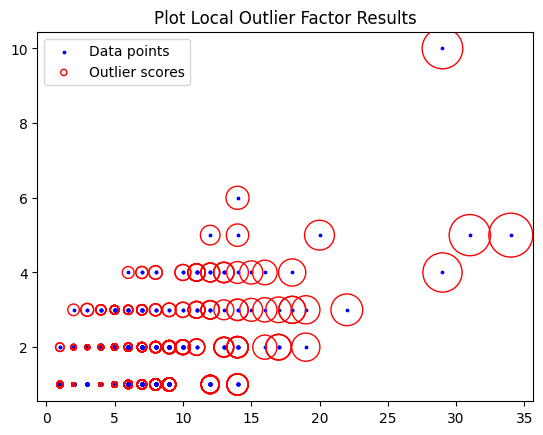

In [29]:
X_scores = lof.negative_outlier_factor_

def update_legend_marker_size(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([20])


plt.scatter(author_features["nb_edge"], 
            author_features["paper_id"], 
            color="blue", 
            s=3.0, 
            label="Data points")

radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

scatter = plt.scatter(
    author_features["nb_edge"],
    author_features["paper_id"],
    s=1000 * radius,
    edgecolors="red",
    facecolors="none",
    label="Outlier scores",
)
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Plot Local Outlier Factor Results")

plt.show()

(array([1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00,
        1.000e+01, 2.800e+01, 4.800e+01, 1.925e+03]),
 array([-11.02745313, -10.0201766 ,  -9.01290007,  -8.00562354,
         -6.99834701,  -5.99107049,  -4.98379396,  -3.97651743,
         -2.9692409 ,  -1.96196438,  -0.95468785]),
 <BarContainer object of 10 artists>)

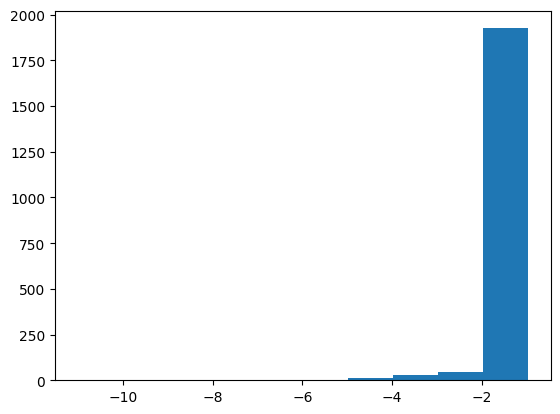

In [30]:
plt.hist(X_scores)
# On filtre en dessous de -2

In [31]:
nx.set_node_attributes(G, dict_color) # resetting
nx.set_node_attributes(G, {key: {"color": "rgba(0, 0, 0, 0.5)"} for key in author_features[X_scores < -2].index})
pyvis_graph(G,
            "graph_authors_outlier_0")

graph_authors_outlier_0.html
